In [8]:
# %pip uninstall librosa
# %pip install librosa==0.9.2

In [9]:
# %pip install pydub

In [1]:
from catboost import CatBoostClassifier

In [2]:
import librosa
import numpy as np
from pydub import AudioSegment
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

/Users/annatekuceva/PycharmProjects/stetoscope/ElectronicStetoscope-Automizer-/.venv/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## load cdpd

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('../data/CDPD/training_data.csv') 

In [6]:
len(df)

942

Отделение данных, вообще нам нужны только данные, которые обязательно имеют в себе Аортальный и Митральный клапаны, или хотя бы один из них, поэтому мы только такие и берем, но посмотреть как может обучиться со всеми данными тоже интересно, поэтому таблицы метрик в конце файла есть и для всех данных и для отобранных

In [7]:
df = df[df['Locations'].isin(['AV+PV+TV+MV', 'AV+PV+MV', 'AV+AV+PV+PV+TV+MV', 'AV+MV+MV', 
                                        'AV+PV+MV+Phc+Phc', 'AV+PV+TV+TV+MV', 'AV+AV+MV+MV', 'AV+AV+PV+TV+MV', 'AV+PV+TV+MV+Phc', 'AV+AV+AV+MV', 'AV+AV+PV+TV+MV+MV', ])&(df['Murmur']!='Unknown')]

In [8]:
len(df)

595

In [9]:
df[df['Patient ID'].isna()]

,Patient ID,Locations,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur grading,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Campaign,Additional ID


In [10]:
df.head()

,Patient ID,Locations,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur grading,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,III/VI,High,Harsh,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,I/VI,Low,Blowing,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,II/VI,Low,Harsh,NaN,NaN,NaN,NaN,NaN,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC2015,NaN


In [37]:
# Определение порядка объединения файлов
order = ['MV', 'AV', 'PV', 'Ph', 'TV']
directory = '../data/CDPD/training_data/'

def combine_audio(filename):
    # Получение списка файлов для текущей строки
    files_to_combine = []
    for location in order:
        file_name = f"{directory}{filename}_{location}.wav"
        if os.path.exists(file_name):
            files_to_combine.append(file_name)
    
    # Объединение файлов
    combined_audio = AudioSegment.empty()
    for file in files_to_combine:
        audio = AudioSegment.from_wav(file)
        combined_audio += audio
    
    # Сохранение объединенного аудио
    output_file_name = f"{directory}{filename}_combined.wav"
    combined_audio.export(output_file_name, format="wav")
    return output_file_name

# Применение функции к каждой строке
# df.apply(combine_audio, axis=1)


In [38]:

def load_audio_data(file_names):
    X = []
    for file_name in tqdm(file_names):
        # Объединение аудиофайлов
        combined_file_name = combine_audio(file_name)
        try:
            # Загрузка объединенного аудиофайла и извлечение признаков
            audio, sr = librosa.load(combined_file_name)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr)
            mfcc_mean = np.mean(mfcc, axis=1)
            
            # Удаление временного объединенного файла
            # os.remove(combined_file_name)
            
            X.append(mfcc_mean)
        except:
            print(combined_file_name)
            continue
    
    return np.array(X)

## load cda

In [14]:
patients = "../data/Пациенты.csv"
norm_dir = "../data/норма"
patology_dir = "../data/патология"

In [15]:
def find_wav_files(directory):
    X = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                audio, sr = librosa.load(os.path.join(root, file))
                mfcc = librosa.feature.mfcc(y=audio, sr=sr)
                mfcc_mean = np.mean(mfcc, axis=1)
                
                X.append(mfcc_mean)
    
    return X

## prepare data

In [16]:
cda = find_wav_files(norm_dir)
norm = len(cda)
cda.extend(find_wav_files(patology_dir))
patology = len(cda) - norm

cda = np.array(cda)
cda_labels = [1]* norm + [0] * patology

In [24]:
# !pip install tqdm

In [17]:
from tqdm import tqdm

In [39]:
file_names_cdpd = list(df['Patient ID']) 

# 1 - normal, 0 - patology
cdpd_data = load_audio_data(file_names_cdpd)

 24%|██▎       | 140/595 [01:25<05:09,  1.47it/s]

../data/CDPD/training_data/50321_combined.wav


100%|██████████| 595/595 [05:14<00:00,  1.89it/s]


In [19]:
cdpd_labels = list(df['Murmur'].apply(lambda x: 1 if x=='Absent' else 0))

In [114]:
# del cdpd_labels[267]

In [20]:
del cdpd_labels[141]

In [21]:
cdpd_labels = np.array(cdpd_labels)

In [22]:
cdpd_data.shape

(594, 20)

In [23]:
cdpd_labels.shape

(594,)

In [24]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(cdpd_data, cdpd_labels, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Добавление новых данных в тестовую выборку
X_test_cdatest = np.vstack((X_test, cda))
y_test_cdatest = np.concatenate((y_test, cda_labels))

X_test_scaled_cdatest = scaler.transform(X_test_cdatest)

print("Новые размеры тестовых данных:")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_test_cdatest shape: {X_test_cdatest.shape}")
print(f"y_test_cdatest shape: {y_test_cdatest.shape}")

Новые размеры тестовых данных:
X_test shape: (119, 20)
y_test shape: (119,)
X_test_cdatest shape: (170, 20)
y_test_cdatest shape: (170,)


In [26]:
# cdpd cda train test
X_train_cda, X_test_cda, y_train_cda, y_test_cda = train_test_split(cda, cda_labels, test_size=0.2, random_state=42)


X_train_cdpd_cda = np.vstack((X_train, X_train_cda))
y_train_cdpd_cda = np.concatenate((y_train, y_train_cda))
X_test_cdpd_cda = np.vstack((X_test, X_test_cda))
y_test_cdpd_cda = np.concatenate((y_test, y_test_cda))

scaler = StandardScaler()
X_train_scaled_cdpd_cda = scaler.fit_transform(X_train_cdpd_cda)
X_test_scaled_cdpd_cda = scaler.transform(X_test_cdpd_cda)

In [28]:
import joblib

In [29]:
joblib.dump(scaler, "./models/binary_standard_scaler.pkl")

['./models/binary_standard_scaler.pkl']

## models

In [30]:
from sklearn.ensemble import AdaBoostClassifier

In [31]:
models_config = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1, 10],
            'penalty': ['l2']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.5, 1]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 150, 200],
            'learning_rate': [1.0, 0.1, 0.01],
            'algorithm': ['SAMME', 'SAMME.R']
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(),
        'params':{
            'n_estimators': [100, 200],
            'max_depth': [3, 4, 6],
            'learning_rate': [0.01, 0.1]
}

} }

## experiments

### train_func

In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix

In [ ]:
import joblib

In [33]:
def train_val(models, X_train_scaled, X_test_scaled, y_train, y_test, experiment=''):
    results = {'model':[], 'Accuracy': [], 'F1-score': [], 'ROC-AUC': [], 'Presidion': [], 'Recall': [], 'Specificity': [], 'Best params': []}
    matrixes = {}
    for name, config in models.items():
        grid_search = GridSearchCV(config['model'], config['params'], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        # пресижн и рекол хде, вы шо
        auc = roc_auc_score(y_test, y_pred_proba)
        pres = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else None

        matrixes[name]=confusion_matrix(y_test, y_pred)
        
        results['model'].append(name) 
        results['Accuracy'].append(round(accuracy, 3))
        results['F1-score'].append(round(f1, 3))
        results['ROC-AUC'].append(round(auc, 3))

        results['Presidion'].append(round(pres, 3))
        results['Recall'].append(round(rec, 3))
        results['Specificity'].append(round(specificity, 3))

        results['Best params'].append(grid_search.best_params_)

        joblib.dump(best_model, f"./models/binary_{experiment}_{name}_best_model.pkl")
        
    return pd.DataFrame(results), matrixes

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def show_matrix(cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])

    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Матрица ошибок')
    plt.show()

### cdpd full

In [ ]:
res_cdpd_full, matrixes_cdpd_full = train_val(models_config,  X_train_scaled, X_test_scaled, y_train, y_test)

In [126]:
# все данные
res_cdpd_full

,model,Accuracy,F1-score,ROC-AUC,Presidion,Recall,Specificity,Best params
0,LogisticRegression,0.799,0.875,0.746,0.801,0.964,0.353,"{'C': 1, 'penalty': 'l2'}"
1,RandomForest,0.783,0.867,0.713,0.784,0.971,0.275,"{'max_depth': 10, 'n_estimators': 200}"
2,GradientBoosting,0.762,0.852,0.728,0.778,0.942,0.275,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,SVC,0.788,0.872,0.756,0.782,0.986,0.255,"{'C': 1, 'kernel': 'rbf'}"
4,CatBoost,0.783,0.866,0.718,0.787,0.964,0.294,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."


In [97]:
# отобранные данные
res_cdpd_full

,model,Accuracy,F1-score,ROC-AUC,Presidion,Recall,Specificity,Best params
0,LogisticRegression,0.849,0.911,0.759,0.852,0.979,0.36,"{'C': 1, 'penalty': 'l2'}"
1,RandomForest,0.807,0.887,0.708,0.826,0.957,0.24,"{'max_depth': None, 'n_estimators': 50}"
2,GradientBoosting,0.832,0.900,0.779,0.849,0.957,0.36,"{'learning_rate': 0.1, 'n_estimators': 50}"
3,SVC,0.815,0.891,0.727,0.833,0.957,0.28,"{'C': 1, 'kernel': 'rbf'}"
4,CatBoost,0.782,0.867,0.711,0.833,0.904,0.32,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."


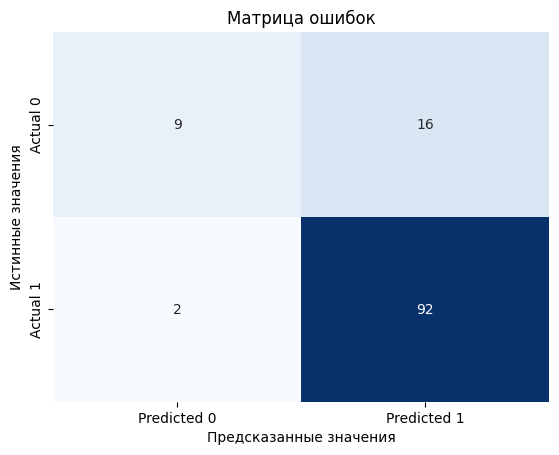

In [90]:
show_matrix(matrixes_cdpd_full['LogisticRegression'])

### cdpd + cda test

In [ ]:
res_cdpd_cda_test, matrixes_cdpd_cda_test = train_val(models_config,  X_train_scaled, X_test_scaled_cdatest, y_train, y_test_cdatest)

In [128]:
# все данные
res_cdpd_cda_test

,model,Accuracy,F1-score,ROC-AUC,Presidion,Recall,Specificity,Best params
0,LogisticRegression,0.642,0.760,0.392,0.627,0.965,0.182,"{'C': 1, 'penalty': 'l2'}"
1,RandomForest,0.629,0.755,0.747,0.617,0.972,0.141,"{'max_depth': 10, 'n_estimators': 200}"
2,GradientBoosting,0.613,0.741,0.462,0.610,0.943,0.141,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,SVC,0.633,0.760,0.831,0.618,0.986,0.131,"{'C': 1, 'kernel': 'rbf'}"
4,CatBoost,0.629,0.753,0.484,0.618,0.965,0.152,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."


In [99]:
# отобранные данные
res_cdpd_cda_test

,model,Accuracy,F1-score,ROC-AUC,Presidion,Recall,Specificity,Best params
0,LogisticRegression,0.618,0.745,0.568,0.601,0.979,0.137,"{'C': 1, 'penalty': 'l2'}"
1,RandomForest,0.629,0.745,0.838,0.613,0.948,0.205,"{'max_depth': None, 'n_estimators': 50}"
2,GradientBoosting,0.600,0.732,0.797,0.592,0.959,0.123,"{'learning_rate': 0.1, 'n_estimators': 50}"
3,SVC,0.588,0.727,0.768,0.585,0.959,0.096,"{'C': 1, 'kernel': 'rbf'}"
4,CatBoost,0.571,0.707,0.770,0.579,0.907,0.123,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."


### cdpd cda full

In [ ]:
res_cdpd_cda, matrixes_cdpd_cda = train_val(models_config, X_train_scaled_cdpd_cda, 
                                    X_test_scaled_cdpd_cda, y_train_cdpd_cda, y_test_cdpd_cda, experiment='cdpd_cda') 

In [130]:
# все данные
res_cdpd_cda

,model,Accuracy,F1-score,ROC-AUC,Presidion,Recall,Specificity,Best params
0,LogisticRegression,0.790,0.863,0.780,0.786,0.957,0.419,"{'C': 10, 'penalty': 'l2'}"
1,RandomForest,0.790,0.864,0.763,0.782,0.964,0.403,"{'max_depth': 10, 'n_estimators': 100}"
2,GradientBoosting,0.765,0.845,0.725,0.776,0.928,0.403,"{'learning_rate': 1, 'n_estimators': 200}"
3,SVC,0.785,0.863,0.806,0.771,0.978,0.355,"{'C': 1, 'kernel': 'rbf'}"
4,CatBoost,0.800,0.872,0.780,0.782,0.986,0.387,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est..."


In [153]:
# отобранные данные
res_cdpd_cda

,model,Accuracy,F1-score,ROC-AUC,Presidion,Recall,Specificity,Best params
0,LogisticRegression,0.831,0.892,0.819,0.827,0.968,0.472,"{'C': 0.1, 'penalty': 'l2'}"
1,RandomForest,0.831,0.894,0.834,0.816,0.989,0.417,"{'max_depth': 5, 'n_estimators': 200}"
2,GradientBoosting,0.838,0.893,0.823,0.854,0.936,0.583,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,SVC,0.808,0.877,0.818,0.817,0.947,0.444,"{'C': 1, 'kernel': 'rbf'}"
4,CatBoost,0.808,0.874,0.806,0.829,0.926,0.500,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti..."


In [36]:
# с адабустом и без фиксированного рандома
res_cdpd_cda

,model,Accuracy,F1-score,ROC-AUC,Presidion,Recall,Specificity,Best params
0,LogisticRegression,0.831,0.892,0.819,0.827,0.968,0.472,"{'C': 0.1, 'penalty': 'l2'}"
1,RandomForest,0.823,0.887,0.824,0.826,0.957,0.472,"{'max_depth': 10, 'n_estimators': 50}"
2,GradientBoosting,0.846,0.899,0.831,0.856,0.947,0.583,"{'learning_rate': 0.1, 'n_estimators': 50}"
3,AdaBoost,0.862,0.910,0.832,0.858,0.968,0.583,"{'algorithm': 'SAMME', 'learning_rate': 1.0, '..."
4,SVC,0.808,0.877,0.818,0.817,0.947,0.444,"{'C': 1, 'kernel': 'rbf'}"
5,CatBoost,0.823,0.884,0.819,0.838,0.936,0.528,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."


In [158]:
res_cdpd_cda.to_excel('results_binary.xlsx')

In [ ]:
RandomForest+++, GradientBoosting+++

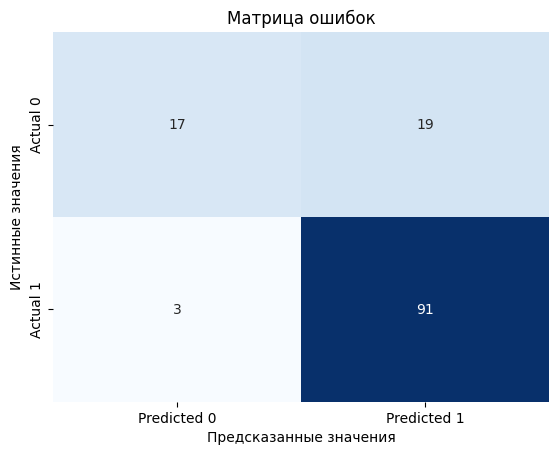

In [154]:
show_matrix(matrixes_cdpd_cda['LogisticRegression'])

### 